In [37]:
from __future__ import print_function, division
# import mdtraj as md
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
# from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
# from mdtraj.geometry import _geometry
# from mdtraj.utils import ensure_type
# from mdtraj.geometry import compute_distances, compute_angles
from itertools import groupby
#from matplotlib import
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
print(torch.__version__)
import torchmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


2.2.2


In [38]:
dmat = np.load("distance_matrix_full_LIG.npy")

In [39]:
def combined_residence_events(data):
  idx = np.arange(len(data[:,0]))
  
  bool = np.where(data<.6,1,0)
  any_event_residue = np.any(bool, axis=1)
  
  comp = np.stack([idx,any_event_residue],axis = 1)
  return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

In [40]:
print(dmat.shape)
# events_all = combined_residence_events(dmat)
# event = events_all[0]
# test = np.mean(dmat[event[0]:event[-1]+1], axis=0)

# print(test.shape)

(1100889, 20)


In [41]:

events_all = combined_residence_events(dmat)
mapping = np.zeros(len(events_all))
avg = np.zeros([len(events_all), len(dmat[0,:])])
print(avg.shape)
print(len(events_all))
print(len(mapping))


count = 0
for event in events_all:
  mapping[count] = len(event)
  avg[count] = np.mean(dmat[event[0]:event[-1]+1], axis=0)
  count += 1
  
print(avg[-1])

plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]

print("Longest five events:", plotevents[:5])

    

(32264, 20)
32264
32264
[1.57703245 1.53463316 1.4436698  1.57972646 1.42884362 1.35897529
 1.28370154 1.25573933 1.12461925 1.17081571 0.9950667  1.131145
 0.77652729 0.68477958 0.50682896 0.35739088 0.41354325 0.44983658
 0.57703733 0.71103626]
Longest five events: [12021  7432  5990  4327  3629]


[12021  7432  5990  4327  3629  3253  2877  2839  2397  2233  2032  2003
  1990  1840  1805  1700  1621  1620  1603  1580]


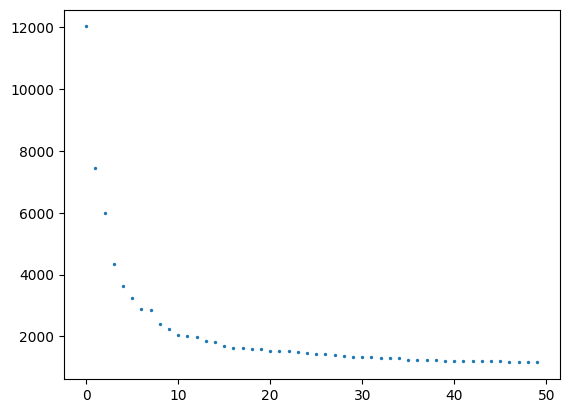

In [42]:
plotevents = np.sort(np.array([len(i) for i in events_all]))[::-1]
ploteventsintime = np.array([len(i) for i in events_all])

plt.scatter(np.arange(50), plotevents[:50], s = 2)
print(plotevents[:20])

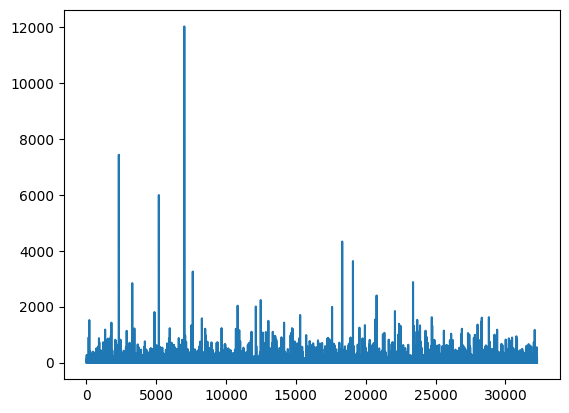

In [43]:
plt.plot(ploteventsintime)

In [63]:
# std = np.std(mapping)
# mean = np.mean(mapping)
# print(std, mean)
# mapping = (mapping - mean)/std
# print(mapping)

print(np.max(mapping))
print(np.min(mapping))
logmapping =  np.log(mapping)

# std = np.std(logmapping)
# mean = np.mean(logmapping)
# print(std, mean)
# logmapping = (logmapping - mean)/std


# print(logmapping)

# print(np.mean(dmat, 0))
# print(np.std(dmat, 0))

amean = np.mean(avg, 0)
astd = np.std(avg, 0)

avg = (avg - amean)/astd

12021.0
1.0


In [64]:
inputs = torch.from_numpy(avg)
inputs = torch.tensor(inputs, dtype=torch.float32)
print(inputs.shape)
print(inputs)
targets= torch.from_numpy(np.reshape(logmapping, (logmapping.shape[0],1)))
targets = torch.tensor(targets, dtype=torch.float32)
# targets = targets.type(torch.LongTensor)
print(targets.shape)
print(targets)
dataset = TensorDataset(inputs, targets)


N = len(dataset)
indices = np.arange(N)
indices = np.random.permutation(indices)
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.85*N)]
test_indices = indices[int(0.85*N):int(1*N)]

print(len(train_indices))
print(train_indices)
train_len = len(train_indices)
print(len(val_indices))
print(val_indices)
val_len = len(val_indices)
print(len(test_indices))
print(test_indices)
test_len = len(test_indices)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size)
test_dataloader = DataLoader(test_set, batch_size)

torch.Size([32264, 20])
tensor([[-0.7676, -0.8582, -1.1161,  ...,  0.7154,  0.5594,  0.4448],
        [-0.2351, -0.5794, -1.1563,  ...,  1.6239,  1.4154,  0.6456],
        [ 0.3142, -0.1558, -0.4539,  ...,  1.4312,  1.3386,  0.8811],
        ...,
        [-0.1801, -0.3523, -0.6488,  ..., -1.2695, -1.5437, -1.5214],
        [ 0.6451,  0.4707,  0.4960,  ..., -1.9197, -1.7348, -1.5075],
        [ 0.2214,  0.2080,  0.1126,  ..., -1.6805, -1.2813, -1.1521]])
torch.Size([32264, 1])
tensor([[4.5643],
        [0.0000],
        [1.0986],
        ...,
        [2.8332],
        [0.0000],
        [5.0626]])
22584
[26993 29156 20327 ... 27944 26986  6564]
4840
[ 5153 18689 26504 ...  7890 13727  5443]
4840
[  527 14393 27239 ... 24967 18609 17082]


/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78599/810009907.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/d8/ljs_0tq104s4vglq15j0zhnr0000gn/T/ipykernel_78599/810009907.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32)


In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(20, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(128, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                           weight_decay=0.001)


In [66]:
def train_model(model, optimizer, num_epochs=25):

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join("tmp_ckpts", 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 999999

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_len
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader
                dataset_size = val_len

            running_loss = 0.0

            all_labels = []
            all_preds = []

            # Iterate over data.
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # print(inputs)
                    logits = model(inputs)
                    loss = F.mse_loss(logits, labels, reduction='mean')
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.append(logits)
                all_labels.append(labels.squeeze(1))


            epoch_loss = running_loss / dataset_size
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            # epoch_acc = accuracy_score(all_labels, all_preds)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            
            # print(phase, "Confusion matrix:")
            # print(confusion_matrix(all_labels, all_preds))
            
            print()

            # deep copy the model
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), best_model_params_path)

        print()
        
    # print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    # model.load_state_dict(torch.load(best_model_params_path))
    return model, all_preds, all_labels

In [67]:
trained_model, ap, al = train_model(model, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.1507

val Loss: 0.8345


Epoch 1/19
----------
train Loss: 0.7628

val Loss: 0.6363


Epoch 2/19
----------
train Loss: 0.6602

val Loss: 0.5377


Epoch 3/19
----------
train Loss: 0.6050

val Loss: 0.5518


Epoch 4/19
----------
train Loss: 0.5815

val Loss: 0.5179


Epoch 5/19
----------
train Loss: 0.5666

val Loss: 0.5067


Epoch 6/19
----------
train Loss: 0.5323

val Loss: 0.4864


Epoch 7/19
----------
train Loss: 0.5146

val Loss: 0.5561


Epoch 8/19
----------
train Loss: 0.5019

val Loss: 0.4957


Epoch 9/19
----------
train Loss: 0.4984

val Loss: 0.4710


Epoch 10/19
----------
train Loss: 0.4846

val Loss: 0.4510


Epoch 11/19
----------
train Loss: 0.4744

val Loss: 0.4656


Epoch 12/19
----------
train Loss: 0.4757

val Loss: 0.4699


Epoch 13/19
----------
train Loss: 0.4714

val Loss: 0.4382


Epoch 14/19
----------
train Loss: 0.4647

val Loss: 0.4596


Epoch 15/19
----------
train Loss: 0.4537

val Loss: 0.4513


Epoch 16/19
------

In [68]:
print(torch.mean(ap))
print(torch.mean(al))

ap = torch.exp(ap)
al = torch.exp(al)

print(torch.mean(ap))
print(torch.mean(al))


tensor(1.4941)
tensor(1.4109)
tensor(27.0240)
tensor(27.9523)


In [69]:
al = torch.Tensor.numpy(al, force=True)
ap = torch.Tensor.numpy(ap, force=True)

In [70]:
top = (-ap).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap[index], "real:", al[index])

predicted [[2341.7363]] real: [740.0001]
predicted [[1317.1746]] real: [229.]
predicted [[1255.9023]] real: [530.0001]
predicted [[1102.312]] real: [822.00006]
predicted [[1092.8464]] real: [1204.0001]
predicted [[1043.1863]] real: [192.99997]
predicted [[921.21075]] real: [1012.00006]
predicted [[906.6688]] real: [1012.99994]
predicted [[898.6407]] real: [533.00006]
predicted [[873.03406]] real: [521.00006]
predicted [[861.28766]] real: [331.99994]
predicted [[825.729]] real: [1317.]
predicted [[775.16296]] real: [686.]
predicted [[771.3909]] real: [396.00006]
predicted [[751.56024]] real: [324.00003]
predicted [[720.2336]] real: [1990.0002]
predicted [[712.82153]] real: [728.]
predicted [[711.8402]] real: [695.00006]
predicted [[693.8481]] real: [561.00006]
predicted [[690.692]] real: [517.0001]


In [71]:
def test_model(model):
    model.eval()
    dataloader = test_dataloader
    dataset_size = test_len
    running_loss = 0.0
            
    all_labels= []
    all_preds= []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = F.mse_loss(logits, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        all_preds.append(logits)
        all_labels.append(labels)


    epoch_loss = running_loss / dataset_size
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {epoch_loss:.4f}')
    
    return all_preds, all_labels



In [72]:
ap2, al2 = test_model(trained_model)

Test Loss: 0.4485


In [73]:
print(torch.mean(ap2))
print(torch.mean(al2))

# ap2= (ap2*std) + mean
# al2= (al2*std) + mean

ap2 = torch.exp(ap2)
al2 = torch.exp(al2)

print(torch.mean(ap2))
print(torch.mean(al2))

al2 = torch.Tensor.numpy(al2, force=True)
ap2 = torch.Tensor.numpy(ap2, force=True)

tensor(1.4950, grad_fn=<MeanBackward0>)
tensor(1.4005)
tensor(26.3885, grad_fn=<MeanBackward0>)
tensor(26.9343)


In [74]:
top = (-al2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[796.7539]] real: [[3252.9995]]
predicted [[508.7717]] real: [[2839.]]
predicted [[510.49808]] real: [[1475.0002]]
predicted [[503.83365]] real: [[1312.]]
predicted [[543.80237]] real: [[1230.]]
predicted [[497.58926]] real: [[1227.9999]]
predicted [[349.36334]] real: [[1105.0002]]
predicted [[1018.6202]] real: [[1101.9999]]
predicted [[478.22626]] real: [[964.00006]]
predicted [[389.44833]] real: [[900.0001]]
predicted [[742.17834]] real: [[877.99994]]
predicted [[1048.6284]] real: [[874.99994]]
predicted [[599.3015]] real: [[874.]]
predicted [[1137.2646]] real: [[864.00006]]
predicted [[270.377]] real: [[822.00006]]
predicted [[340.29926]] real: [[818.0001]]
predicted [[270.2414]] real: [[814.9999]]
predicted [[529.67145]] real: [[785.]]
predicted [[329.06744]] real: [[769.99994]]
predicted [[544.8972]] real: [[756.9999]]


In [75]:
top = (-ap2).argsort(axis=0)[:20]
for index in top:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[1305.4973]] real: [[251.00003]]
predicted [[1194.9485]] real: [[205.99998]]
predicted [[1165.1566]] real: [[590.99994]]
predicted [[1137.2646]] real: [[864.00006]]
predicted [[1048.6284]] real: [[874.99994]]
predicted [[1018.6202]] real: [[1101.9999]]
predicted [[967.2273]] real: [[633.]]
predicted [[960.2684]] real: [[657.0001]]
predicted [[919.127]] real: [[588.0001]]
predicted [[796.7539]] real: [[3252.9995]]
predicted [[744.33887]] real: [[520.0001]]
predicted [[742.17834]] real: [[877.99994]]
predicted [[719.84625]] real: [[400.00003]]
predicted [[672.28674]] real: [[91.]]
predicted [[652.60297]] real: [[282.99997]]
predicted [[599.3015]] real: [[874.]]
predicted [[588.6448]] real: [[216.00002]]
predicted [[574.275]] real: [[418.]]
predicted [[565.32965]] real: [[710.0001]]
predicted [[561.86664]] real: [[290.]]


In [76]:
bottom = (ap2).argsort(axis=0)[:20]
for index in bottom:
  print("predicted", ap2[index], "real:", al2[index])

predicted [[1.0934976]] real: [[1.]]
predicted [[1.0936859]] real: [[1.]]
predicted [[1.0946711]] real: [[1.]]
predicted [[1.0959258]] real: [[1.]]
predicted [[1.0963967]] real: [[1.]]
predicted [[1.0964856]] real: [[1.]]
predicted [[1.0968794]] real: [[1.]]
predicted [[1.0969428]] real: [[1.]]
predicted [[1.09771]] real: [[1.]]
predicted [[1.0980561]] real: [[1.]]
predicted [[1.0987427]] real: [[1.]]
predicted [[1.1001688]] real: [[1.]]
predicted [[1.10047]] real: [[1.]]
predicted [[1.1009973]] real: [[1.]]
predicted [[1.1020051]] real: [[1.]]
predicted [[1.1033431]] real: [[1.]]
predicted [[1.1055262]] real: [[1.]]
predicted [[1.1057352]] real: [[1.]]
predicted [[1.1062115]] real: [[1.]]
predicted [[1.1070179]] real: [[1.]]


r2: 0.7490323017310174


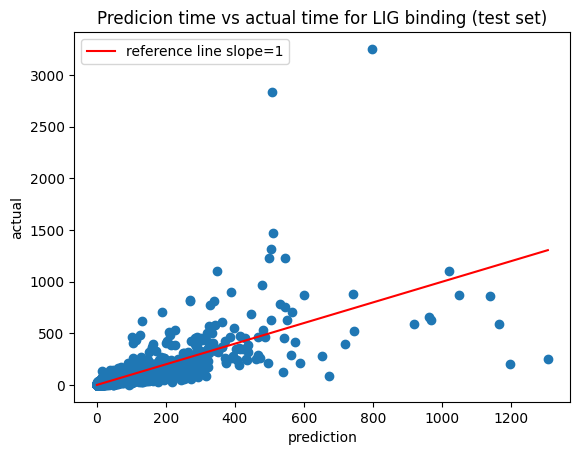

In [94]:
plt.scatter(ap2,al2)
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(min(ap2[:,0]), max(ap2[:,0]),20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()

r2: 0.7490323017310174


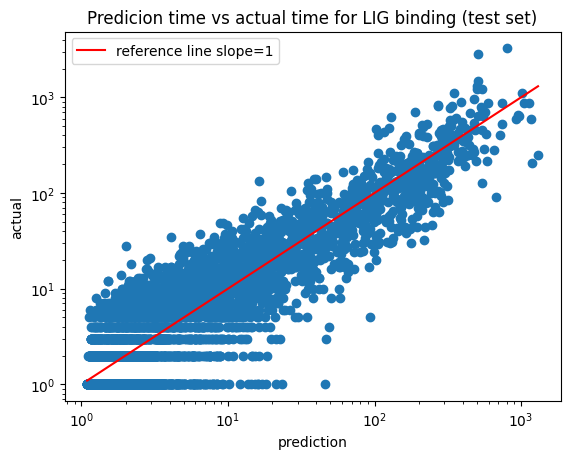

In [85]:
plt.scatter(ap2,al2)
plt.xscale("log")
plt.yscale("log")
r=np.corrcoef(ap2[:,0], al2[:,0])
print("r2:",r[0,1])

# line_fit=np.polyfit(ap2[:,0], al2[:,0], 1)
x = np.linspace(min(ap2[:,0]), max(ap2[:,0]),20)
y = 1*x
plt.plot(x,y,c='r', label='reference line slope=1')
plt.title("Predicion time vs actual time for LIG binding (test set)")
plt.ylabel('actual')
plt.legend()
plt.xlabel('prediction')
plt.show()